In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import model_selection
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, accuracy_score

from Models import UciAdultsClassifier
from Datasets import TabularDataset

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
columns=[
    'age', 
    'workclass', 
    'fnlwgt', 
    'education', 
    'education-num',
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex',
    'capital-gain', 
    'capital-loss', 
    'hours-per-week', 
    'native-country',
    'income']
adult_train_df = pd.read_csv('adult_train.csv', sep=",", header=None, names=columns)
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

32,561 registros a las 2020-08-24 01:18:19.490784


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
adult_train_df.replace(to_replace=' ?', value= np.nan, inplace=True)
adult_train_df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [4]:
adult_train_df.dropna(inplace=True)
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

30,162 registros a las 2020-08-24 01:18:19.549952


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
adult_train_df['income'].replace({' <=50K': 0, ' >50K': 1}, inplace=True)
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

30,162 registros a las 2020-08-24 01:18:19.573524


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [6]:
adult_train_df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income             int64
dtype: object

In [7]:
categorical_columns = ['occupation', 'workclass', 'native-country', 'marital-status', 'race', 'relationship', 'sex'] 
continius_columns = ['age', 'capital-gain', 'education-num', 'hours-per-week', 'capital-loss']

q_categorical_columns = len(categorical_columns)
q_continius_columns = len(continius_columns)
q_categorical_columns, q_continius_columns

(7, 5)

In [8]:
categorical_columns_mapping = {}

for column in categorical_columns:
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(adult_train_df[column])
    adult_train_df[column] = label_encoder.transform(adult_train_df[column])
    
    categorical_columns_mapping[column] = (label_encoder.classes_, label_encoder.transform(label_encoder.classes_))
    
categorical_columns_mapping

{'occupation': (array([' Adm-clerical', ' Armed-Forces', ' Craft-repair',
         ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners',
         ' Machine-op-inspct', ' Other-service', ' Priv-house-serv',
         ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support',
         ' Transport-moving'], dtype=object),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])),
 'workclass': (array([' Federal-gov', ' Local-gov', ' Private', ' Self-emp-inc',
         ' Self-emp-not-inc', ' State-gov', ' Without-pay'], dtype=object),
  array([0, 1, 2, 3, 4, 5, 6])),
 'native-country': (array([' Cambodia', ' Canada', ' China', ' Columbia', ' Cuba',
         ' Dominican-Republic', ' Ecuador', ' El-Salvador', ' England',
         ' France', ' Germany', ' Greece', ' Guatemala', ' Haiti',
         ' Holand-Netherlands', ' Honduras', ' Hong', ' Hungary', ' India',
         ' Iran', ' Ireland', ' Italy', ' Jamaica', ' Japan', ' Laos',
         ' Mexico', ' Nicaragua', ' Ou

In [9]:
adult_train_df.drop(['fnlwgt', 'education'], axis=1, inplace=True)
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

30,162 registros a las 2020-08-24 01:18:19.654897


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,13,2,3,0,4,1,0,0,13,38,0
2,38,2,9,0,5,1,4,1,0,0,40,38,0
3,53,2,7,2,5,0,2,1,0,0,40,38,0
4,28,2,13,2,9,5,2,0,0,0,40,4,0


In [10]:
scaler = StandardScaler()
adult_train_df[continius_columns] = scaler.fit_transform(adult_train_df[continius_columns])
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

30,162 registros a las 2020-08-24 01:18:19.696900


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.042796,5,1.128918,4,0,1,4,1,0.146092,-0.218586,-0.077734,38,0
1,0.880288,4,1.128918,2,3,0,4,1,-0.147445,-0.218586,-2.331531,38,0
2,-0.033340,2,-0.439738,0,5,1,4,1,-0.147445,-0.218586,-0.077734,38,0
3,1.108695,2,-1.224066,2,5,0,2,1,-0.147445,-0.218586,-0.077734,38,0
4,-0.794697,2,1.128918,2,9,5,2,0,-0.147445,-0.218586,-0.077734,4,0


In [11]:
adult_train_df.columns

Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'income'],
      dtype='object')

In [12]:
X_columns = [
    'age', 
    'workclass', 
    'education-num', 
    'marital-status', 
    'occupation',
    'relationship', 
    'race', 
    'sex', 
    'capital-gain', 
    'capital-loss',
    'hours-per-week', 
    'native-country'
]
Y_column = ['income']
X_ndarray = adult_train_df[X_columns].to_numpy()
X_ndarray, X_ndarray.shape

(array([[ 4.27957113e-02,  5.00000000e+00,  1.12891838e+00, ...,
         -2.18585975e-01, -7.77341106e-02,  3.80000000e+01],
        [ 8.80288144e-01,  4.00000000e+00,  1.12891838e+00, ...,
         -2.18585975e-01, -2.33153070e+00,  3.80000000e+01],
        [-3.33399643e-02,  2.00000000e+00, -4.39738199e-01, ...,
         -2.18585975e-01, -7.77341106e-02,  3.80000000e+01],
        ...,
        [ 1.48937355e+00,  2.00000000e+00, -4.39738199e-01, ...,
         -2.18585975e-01, -7.77341106e-02,  3.80000000e+01],
        [-1.25151078e+00,  2.00000000e+00, -4.39738199e-01, ...,
         -2.18585975e-01, -1.74721307e+00,  3.80000000e+01],
        [ 1.03255950e+00,  3.00000000e+00, -4.39738199e-01, ...,
         -2.18585975e-01, -7.77341106e-02,  3.80000000e+01]]),
 (30162, 12))

In [13]:
Y_ndarray = adult_train_df[Y_column].to_numpy().squeeze()
Y_ndarray

array([0, 0, 0, ..., 0, 0, 1])

In [14]:
categorical_column_indexes = [adult_train_df.columns.get_loc(column) for column in categorical_columns]
continius_column_indexes = [adult_train_df.columns.get_loc(column) for column in continius_columns]
categorical_column_indexes, continius_column_indexes

([4, 1, 11, 3, 6, 5, 7], [0, 8, 2, 10, 9])

In [15]:
X_ndarray[:10, categorical_column_indexes]

array([[ 0.,  5., 38.,  4.,  4.,  1.,  1.],
       [ 3.,  4., 38.,  2.,  4.,  0.,  1.],
       [ 5.,  2., 38.,  0.,  4.,  1.,  1.],
       [ 5.,  2., 38.,  2.,  2.,  0.,  1.],
       [ 9.,  2.,  4.,  2.,  2.,  5.,  0.],
       [ 3.,  2., 38.,  2.,  4.,  5.,  0.],
       [ 7.,  2., 22.,  3.,  2.,  1.,  0.],
       [ 3.,  4., 38.,  2.,  4.,  0.,  1.],
       [ 9.,  2., 38.,  4.,  4.,  1.,  0.],
       [ 3.,  2., 38.,  2.,  4.,  0.,  1.]])

Datasets

In [16]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_ndarray, Y_ndarray, test_size = 0.2, random_state = 7)

In [17]:
X_train[:5, categorical_column_indexes]

array([[ 3.,  2., 38.,  2.,  4.,  0.,  1.],
       [ 0.,  5., 38.,  0.,  4.,  4.,  0.],
       [ 6.,  2., 38.,  2.,  4.,  0.,  1.],
       [ 9.,  5., 38.,  2.,  4.,  0.,  1.],
       [ 3.,  2., 38.,  2.,  4.,  0.,  1.]])

In [18]:
train_ds = TabularDataset(
    continius_features=X_train[:,continius_column_indexes], 
    categorical_features=X_train[:,categorical_column_indexes], 
    y=Y_train, 
    normalize=False
)

test_ds = TabularDataset(
    continius_features=X_test[:,continius_column_indexes], 
    categorical_features=X_test[:,categorical_column_indexes], 
    y=Y_test, 
    normalize=False
)

In [19]:
for i in range(10):
    x_continius, x_categorical, y = train_ds[i]
    print(f'{i} -> X_continius: {x_continius[:4]}, X_categorical: {x_categorical[:4]} Y: {y}')

0 -> X_continius: tensor([ 0.9564,  0.8379, -0.4397, -0.0777]), X_categorical: tensor([ 3,  2, 38,  2]) Y: tensor([1.])
1 -> X_continius: tensor([ 0.8803, -0.1474, -0.4397,  0.4231]), X_categorical: tensor([ 0,  5, 38,  0]) Y: tensor([0.])
2 -> X_continius: tensor([ 1.9462, -0.1474, -0.4397, -0.0777]), X_categorical: tensor([ 6,  2, 38,  2]) Y: tensor([0.])
3 -> X_continius: tensor([ 1.0326, -0.1474,  1.5211, -0.0777]), X_categorical: tensor([ 9,  5, 38,  2]) Y: tensor([0.])
4 -> X_continius: tensor([ 1.3371,  0.4612,  1.1289, -0.0777]), X_categorical: tensor([ 3,  2, 38,  2]) Y: tensor([0.])
5 -> X_continius: tensor([-0.1095, -0.1474, -0.4397,  0.3396]), X_categorical: tensor([12,  2, 38,  0]) Y: tensor([0.])
6 -> X_continius: tensor([-0.9470,  0.6250, -0.4397, -0.0777]), X_categorical: tensor([ 6,  2, 38,  4]) Y: tensor([0.])
7 -> X_continius: tensor([ 2.9360,  2.5599,  2.3054, -0.0777]), X_categorical: tensor([ 4,  3, 38,  2]) Y: tensor([1.])
8 -> X_continius: tensor([-0.9470, -0.14

Dataloaders

In [20]:
train_dl = DataLoader(train_ds, batch_size=1000, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1000, shuffle=False)

In [21]:
for x_continius, x_categorical, y in train_dl:
    print(f'{x_continius.shape}, {x_categorical.shape}, {y.shape}')

torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), to

### Training the net

In [22]:
embedding_dims = []
for column in categorical_columns:
    q_unique_values = len(adult_train_df[column].unique())
    embedding_size = min(q_unique_values//2, 50)
    embedding_dims.append((q_unique_values, embedding_size))

embedding_dims

[(14, 7), (7, 3), (41, 20), (7, 3), (5, 2), (6, 3), (2, 1)]

In [23]:
model = UciAdultsClassifier(q_continius_features=q_continius_columns, q_categorical_features=q_categorical_columns, embedding_dims=embedding_dims)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
bceloss_fn = nn.BCELoss(reduction='mean')
epochs=100

In [24]:
model

UciAdultsClassifier(
  (embeddings_layer): ModuleList(
    (0): Embedding(14, 7)
    (1): Embedding(7, 3)
    (2): Embedding(41, 20)
    (3): Embedding(7, 3)
    (4): Embedding(5, 2)
    (5): Embedding(6, 3)
    (6): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (layer1): Sequential(
    (0): Linear(in_features=44, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Linear(in_feature

In [25]:
losses = model.fit(train_dl=train_dl, epochs=epochs, loss_fn=bceloss_fn, opt=optimizer)

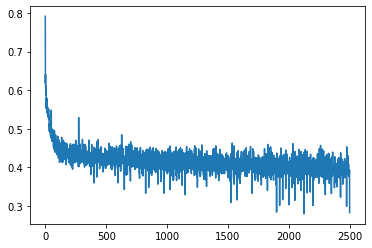

In [26]:
plt.plot(range(len(losses)), losses)

In [29]:
x_continius_train, x_categorical_train, y_train = train_ds.reverse_transform()

In [30]:
x_continius_test, x_categorical_test, y_test = test_ds.reverse_transform()

### Validating the net

In [31]:
y_train_pred = model.predict(train_dl).numpy().squeeze()

In [32]:
y_test_pred = model.predict(test_dl).numpy().squeeze()

In [33]:
aucroc_train = roc_auc_score(y_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.9213798352483734


In [34]:
accuracy_train = accuracy_score(y_train, [1 if pred >= .5 else 0 for pred in y_train_pred])
print(f'Accuracy in training: {accuracy_train}')

Accuracy in training: 0.8737204194123254


In [37]:
aucroc_test = roc_auc_score(y_test, y_test_pred)
print(f'Auc Roc in test: {aucroc_test}')

Auc Roc in test: 0.8630574116688894


In [38]:
accuracy_test = accuracy_score(y_test, [1 if pred >= .5 else 0 for pred in y_test_pred])
print(f'Accuracy in test: {accuracy_train}')

Accuracy in test: 0.8737204194123254
